## EventNet Creation

EventNet consists of 2 models: a masking model and a binary classification model. In order to mask potential event-related deformation in interferograms, a masking model is required. An event presence model is then trained in order automatically provide a probabilistic answer on whether there is an event in the masked image. 

Thus, the four main steps are:
1. Create a Dataset with Simulated Wrapped Interferograms and their Masks
2. Train a masking model in the Simulated Masking Dataset
3. Create a Binary Classification Dataset of Masks and their Presence
4. Train a Binary Classification Model from the Mask/Presence Dataset

### Imports

In [1]:
if "NOTEBOOK_INITIATED_FLAG" not in globals():
    NOTEBOOK_INITIATED_FLAG = True
    %cd ..
%pwd

import numpy as np
import matplotlib.pyplot as plt

from os import environ

environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from insar_eventnet.config import SYNTHETIC_DIR
from insar_eventnet.io import make_simulated_dataset, split_dataset
from insar_eventnet.training import train
from insar_eventnet.inference import mask_simulated, plot_imgs
from insar_eventnet.sarsim import gen_simulated_deformation, gen_sim_noise

plt.rcParams["figure.figsize"] = (20, 10)

/home/andrew/repos/AI-Event-Monitoring
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 SUPER, compute capability 7.5


### Simulated Events

By using the <i><b>gen_simulated_deformation</b></i> and <i><b>gen_sim_noise</b></i> functions, we can create simulated interferogram datasets containing "Positives" which contain events and "Negatives" which contain noise. <i><b>gen_simulated_deformation</b></i> generates our "Positive" training examples and supports 'quake', 'dyke', and 'sill' event types. <i><b>gen_sim_noise</b></i> generates our "Negative" training images with either atmospheric and topographic noise or gaussian noise. The gaussian noise is primarily used as a negative representing unmasked incoherence.

Each of these functions returns 4 things: an unwrapped phase image, a deformation mask, a wrapped image, and a presence value. These are used as follows:
- <b>Unwrapped</b>: Only used as a visual aid. Since gen_simulated_deformation contaminates this image, you must use the Okada class manually if you want an accurate displacement image.
- <b>Wrapped</b>: This is the primary input for training the masking model. Wrapped images are turned into deformation masks.
- <b>Deformation Mask</b>: This is used as a ground truth for training. Pixels are set to 1 where there is an event and its phase is greater than 2π.
- <b>Presenc</b>e: [1] if the image contains a deformation event (it was from gen_simulated_deformation), otherwise its [0] (it was from gen_sim_noise).



Deformation Presence: [1]
Mixed Noise Presence: [0]
Gauss Noise Presence: [0]


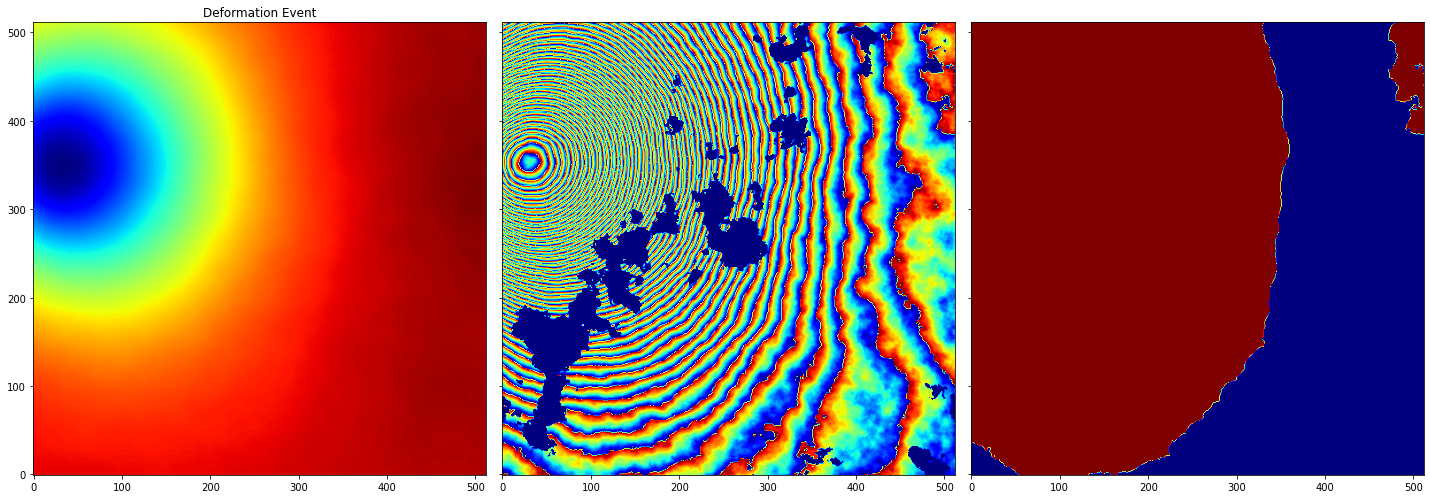

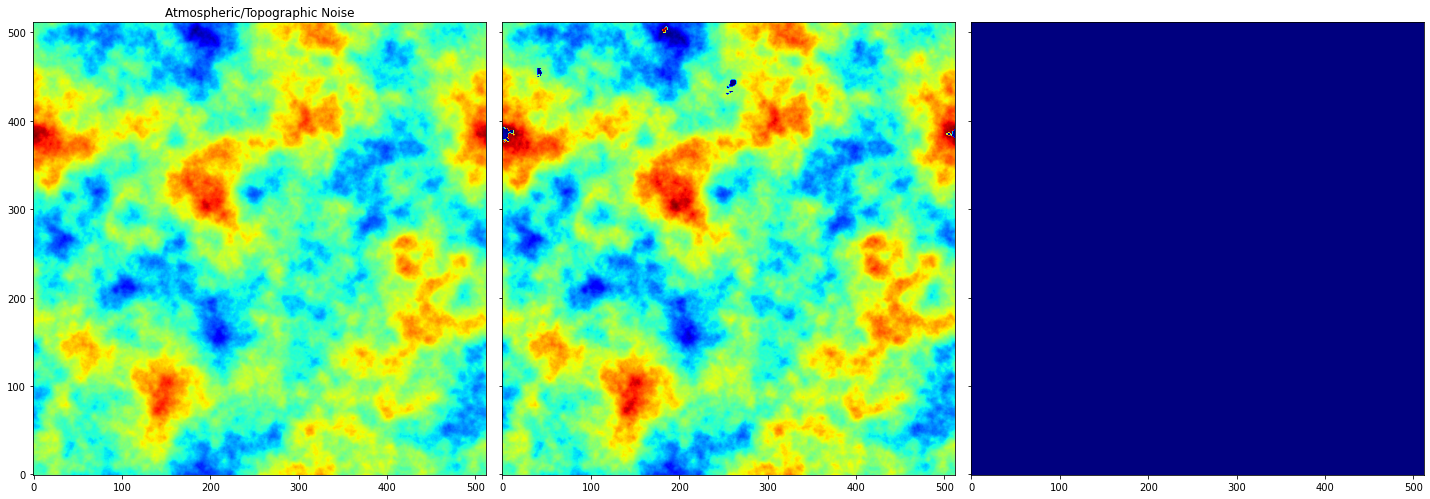

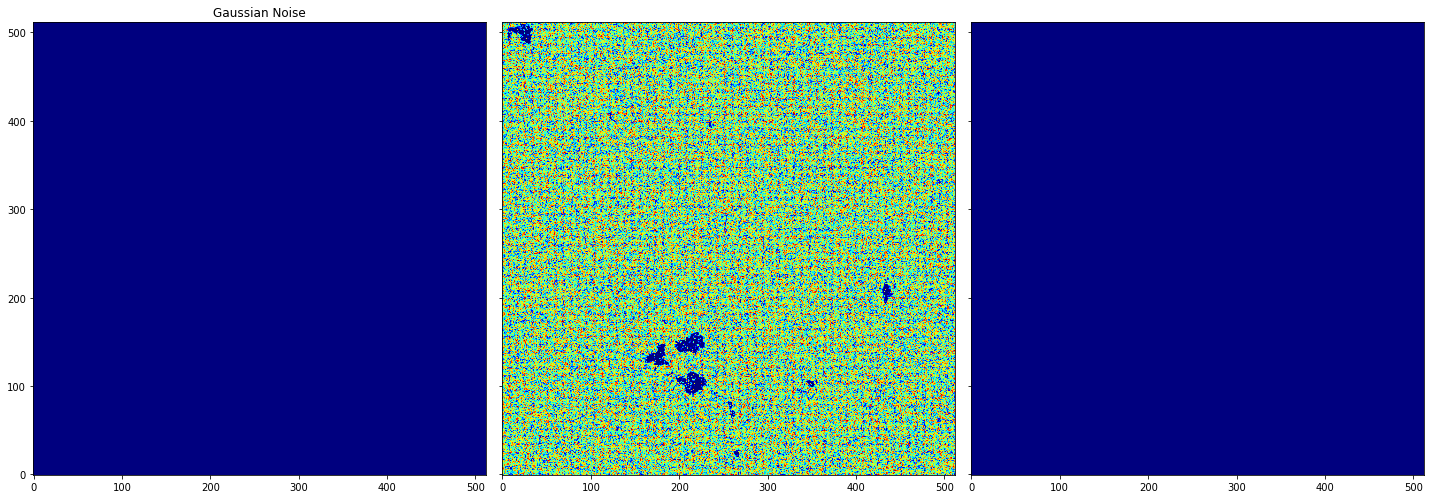

In [2]:
seed = 232323
tile_size = 512
event_type = "quake"

unwrapped_def, masked_def, wrapped_def, presence_def = gen_simulated_deformation(
    seed=seed, tile_size=tile_size, event_type=event_type
)
unwrapped_mix, masked_mix, wrapped_mix, presence_mix = gen_sim_noise(
    seed=seed, tile_size=tile_size
)
unwrapped_gsn, masked_gsn, wrapped_gsn, presence_gsn = gen_sim_noise(
    seed=seed, tile_size=tile_size, gaussian_only=True
)

print(f"Deformation Presence: {presence_def}")
print(f"Mixed Noise Presence: {presence_mix}")
print(f"Gauss Noise Presence: {presence_gsn}")

_, [axs_unwrapped_def, axs_wrapped_def, axs_mask_def] = plt.subplots(
    1, 3, sharex=True, sharey=True, tight_layout=True
)

_, [axs_unwrapped_mix, axs_wrapped_mix, axs_mask_mix] = plt.subplots(
    1, 3, sharex=True, sharey=True, tight_layout=True
)

_, [axs_unwrapped_gsn, axs_wrapped_gsn, axs_mask_gsn] = plt.subplots(
    1, 3, sharex=True, sharey=True, tight_layout=True
)

axs_unwrapped_def.set_title("Deformation Event")
axs_unwrapped_mix.set_title("Atmospheric/Topographic Noise")
axs_unwrapped_gsn.set_title("Gaussian Noise")

axs_unwrapped_def.imshow(unwrapped_def, origin="lower", cmap="jet")
axs_unwrapped_mix.imshow(unwrapped_mix, origin="lower", cmap="jet")
axs_unwrapped_gsn.imshow(unwrapped_gsn, origin="lower", cmap="jet")
axs_wrapped_def.imshow(wrapped_def, origin="lower", cmap="jet")
axs_wrapped_mix.imshow(wrapped_mix, origin="lower", cmap="jet")
axs_wrapped_gsn.imshow(wrapped_gsn, origin="lower", cmap="jet")
axs_mask_def.imshow(masked_def, origin="lower", cmap="jet", vmin=0.0, vmax=1.0)
axs_mask_mix.imshow(masked_mix, origin="lower", cmap="jet", vmin=0.0, vmax=1.0)
axs_mask_gsn.imshow(masked_gsn, origin="lower", cmap="jet", vmin=0.0, vmax=1.0)

plt.show()

### Create Dataset of Simulated Events

The <i><b>make_simulated_dataset</b></i> function is used to generate the datasets for training the masking model. It creates a dataset of specified size with a positive-to-negative ratio of 60/40, where 30% of the negatives are atmospheric noise and 10% are gaussian noise. The ratios can be modified easily in the source code, but the default ratios are what has worked best so far.

<i>Note</i>: while you can train a binary model with the same dataset that you train the masking model with, it is not recommended.

In [3]:
name = "mask_model_dataset"

amount = (
    2000  # The number of images to generate. ~1500 is sufficient for a decent model.
)
seed = 0  # The seed for the random number generators
tile_size = 512  # The size of the tiles to generate
crop_size = 512  # Crop size for model (same as tile_size for our U-Net currently)
split = 0.2  # The percentage of the dataset to use for validation

name, count, dir_name, distribution, dataset_info = make_simulated_dataset(
    name, SYNTHETIC_DIR, amount, seed, tile_size, crop_size
)

dataset_path = SYNTHETIC_DIR.__str__() + "/" + dir_name

num_train, num_validation = split_dataset(dataset_path, split)

print("")
print(f"Dataset Path:      {dataset_path}")
print(f"Train Amount:      {num_train}")
print(f"Validation Amount: {num_validation}")

Generated 10 of 2000 simulated interferogram pairs.
Generated 20 of 2000 simulated interferogram pairs.
Generated 30 of 2000 simulated interferogram pairs.
Generated 40 of 2000 simulated interferogram pairs.
Generated 50 of 2000 simulated interferogram pairs.
Generated 60 of 2000 simulated interferogram pairs.
Generated 70 of 2000 simulated interferogram pairs.
Generated 80 of 2000 simulated interferogram pairs.
Generated 90 of 2000 simulated interferogram pairs.
Generated 100 of 2000 simulated interferogram pairs.
Generated 110 of 2000 simulated interferogram pairs.
Generated 120 of 2000 simulated interferogram pairs.
Generated 130 of 2000 simulated interferogram pairs.
Generated 140 of 2000 simulated interferogram pairs.
Generated 150 of 2000 simulated interferogram pairs.
Generated 160 of 2000 simulated interferogram pairs.
Generated 170 of 2000 simulated interferogram pairs.
Generated 180 of 2000 simulated interferogram pairs.
Generated 190 of 2000 simulated interferogram pairs.
Ge

Generated 1550 of 2000 simulated interferogram pairs.
Generated 1560 of 2000 simulated interferogram pairs.
Generated 1570 of 2000 simulated interferogram pairs.
Generated 1580 of 2000 simulated interferogram pairs.
Generated 1590 of 2000 simulated interferogram pairs.
Generated 1600 of 2000 simulated interferogram pairs.
Generated 1610 of 2000 simulated interferogram pairs.
Generated 1620 of 2000 simulated interferogram pairs.
Generated 1630 of 2000 simulated interferogram pairs.
Generated 1640 of 2000 simulated interferogram pairs.
Generated 1650 of 2000 simulated interferogram pairs.
Generated 1660 of 2000 simulated interferogram pairs.
Generated 1670 of 2000 simulated interferogram pairs.
Generated 1680 of 2000 simulated interferogram pairs.
Generated 1690 of 2000 simulated interferogram pairs.
Generated 1700 of 2000 simulated interferogram pairs.
Generated 1710 of 2000 simulated interferogram pairs.
Generated 1720 of 2000 simulated interferogram pairs.
Generated 1730 of 2000 simul

### Train UNet Masking Model

The main model we use for masking is a form of U-Net. It is also possible to use a ResNet-like model by switching "unet" to "resnet", but the "unet" tends to produce better results in less time. The default hyperparameters here should be sufficient for getting good results.

In [4]:
model_name = "mask_modelV36"
model_type = "unet"
dataset_path = dataset_path
input_shape = 512
epochs = 15
filters = 64
batch_size = 1
learning_rate = 1e-4
use_wandb = False
using_aws = False
using_jupyter = True
logs_dir = ""

mask_model, mask_history = train(
    model_name,
    dataset_path,
    model_type,
    input_shape,
    epochs,
    filters,
    batch_size,
    learning_rate,
    use_wandb,
    using_aws,
    using_jupyter,
    logs_dir,
)

Epoch 1/15
1602/1602 [==============================] - ETA: 0s - loss: 0.0757 - mean_squared_error: 0.1515 - mean_absolute_error: 0.3034
Epoch 1: val_loss improved from inf to 0.03571, saving model to ./data/output/models/checkpoints/mask_modelV36
INFO:tensorflow:Assets written to: ./data/output/models/checkpoints/mask_modelV36/assets
1602/1602 [==============================] - 65s 34ms/step - loss: 0.0757 - mean_squared_error: 0.1515 - mean_absolute_error: 0.3034 - val_loss: 0.0357 - val_mean_squared_error: 0.0714 - val_mean_absolute_error: 0.1696
Epoch 2/15
1602/1602 [==============================] - ETA: 0s - loss: 0.0303 - mean_squared_error: 0.0606 - mean_absolute_error: 0.1406
Epoch 2: val_loss improved from 0.03571 to 0.02510, saving model to ./data/output/models/checkpoints/mask_modelV36
INFO:tensorflow:Assets written to: ./data/output/models/checkpoints/mask_modelV36/assets
1602/1602 [==============================] - 53s 33ms/step - loss: 0.0303 - mean_squared_error: 0.060

In [5]:
def print_model_info(model, history):
    losses = history.history["loss"]
    val_losses = history.history["val_loss"]

    min_loss = min(losses)
    min_val_loss = min(val_losses)

    min_loss_at = losses.index(min_loss)
    min_val_loss_at = val_losses.index(min_val_loss)

    summary_list = []
    model.summary(print_fn=lambda x: summary_list.append(" " + x))
    summary_string = "\n".join(summary_list[1:])

    print(
        f"\n",
        f"Model Name:    {model_name}\n",
        f"Model Type:    {model_type}\n",
        f"\n",
        f"Minimum Training Loss:   {min_loss: 0.15f} at epoch {min_loss_at}.\n",
        f"Minimum Validation Loss: {min_val_loss: 0.15f} at epoch {min_val_loss_at}.\n"
        f"\n",
        f"All Training Losses:\n {losses}\n",
        f"\n",
        f"All Validation Losses:\n {val_losses}\n",
        f"\n",
        f"Model Parameters from History:\n {history.params}\n",
        f"\n",
        f"Model Summary:\n{summary_string}\n",
    )


print_model_info(mask_model, mask_history)


 Model Name:    mask_modelV36
 Model Type:    unet
 
 Minimum Training Loss:    0.003421352710575 at epoch 14.
 Minimum Validation Loss:  0.016181165352464 at epoch 8.

 All Training Losses:
 [0.07569071650505066, 0.030308237299323082, 0.029678167775273323, 0.021265355870127678, 0.01732829585671425, 0.015977075323462486, 0.012531604617834091, 0.009357718750834465, 0.007819187827408314, 0.006264141295105219, 0.005277558695524931, 0.004769966006278992, 0.004400080535560846, 0.005891966633498669, 0.0034213527105748653]
 
 All Validation Losses:
 [0.03570585325360298, 0.025097331032156944, 0.0207799281924963, 0.020895613357424736, 0.017689848318696022, 0.035025373101234436, 0.016706326976418495, 0.016934551298618317, 0.016181165352463722, 0.018362348899245262, 0.01706208847463131, 0.01730268821120262, 0.016937458887696266, 0.017519645392894745, 0.017228467389941216]
 
 Model Parameters from History:
 {'verbose': 1, 'epochs': 15, 'steps': 1602}
 
 Model Summary:
 __________________________

### Run Inference on a Simulated Event with the Masking Model

Now that we have a masking model, we can do a basic evaluation of our model using the simulated data. As you will see, the U-Net outputs pixel values that can range from slightly below 0 to slightly above 1. These values can be roughly thought of as a confidence in whether the pixel represents deformation from an event.

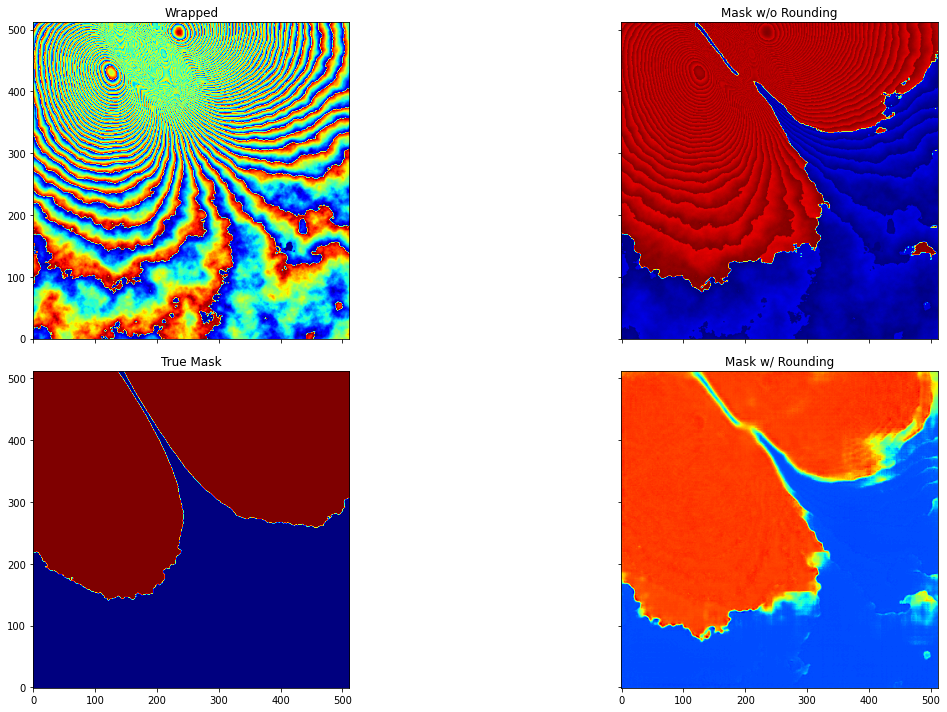

In [6]:
def eval_mask_model(
    model, event_type, seed, noise_only, round_mask, zero_output, tile_size, crop_size
):
    if not noise_only:
        unwrapped, mask, wrapped, presence = gen_simulated_deformation(
            seed=seed, tile_size=tile_size, event_type=event_type
        )
    else:
        unwrapped, mask, wrapped, presence = gen_sim_noise(
            seed=seed, tile_size=tile_size
        )

    wrapped = wrapped.reshape((1, tile_size, tile_size, 1))
    mask_pred = np.float32(model.predict(wrapped).reshape((crop_size, crop_size)))
    wrapped = wrapped.reshape((tile_size, tile_size))

    mask_pred_rounded = np.copy(mask_pred)

    if round_mask:
        tolerance = 0.7
        round_up = mask_pred >= tolerance
        round_down = mask_pred < tolerance
        mask_pred_rounded[round_up] = 1
        mask_pred_rounded[round_down] = 0

    if zero_output:
        zeros = x == 0
        mask[zeros] = 0
        mask_pred_rounded[zeros] = 0

    return wrapped, mask, mask_pred, mask_pred_rounded


event_type = "quake"
seed = 0
noise_only = False
round_mask = True
zero_output = False

wrapped, mask, mask_pred, mask_pred_rounded = eval_mask_model(
    mask_model,
    event_type,
    seed,
    noise_only,
    round_mask,
    zero_output,
    tile_size,
    crop_size,
)

plot_imgs(wrapped, mask, mask_pred, mask_pred_rounded)

### Create Dataset of Simulated Events with Masks from the UNet

As mentioned before, it is possible to train the binary classification model on any dataset generated by make_simulated_dataset; however, each masking model may have slight quirks and imperfections which can result in worse performance when a binary model is expecting perfection. Thus, it is better to use the masking model to generate the masks for training the binary classification model. This is done by including the masking model's path in the function arguments.

In [7]:
name = "classification_model_dataset"
model_path = "data/output/models/checkpoints/" + model_name

amount = 1000  # A size of ~1000 usually produces good results.
split = 0.1

name, count, dir_name, _, _ = make_simulated_dataset(
    name, SYNTHETIC_DIR, amount, seed, tile_size, crop_size, model_path=model_path
)

dataset_path = SYNTHETIC_DIR.__str__() + "/" + dir_name

num_train, num_validation = split_dataset(dataset_path, split)

print("")
print(f"Dataset Path:      {dataset_path}")
print(f"Train Amount:      {num_train}")
print(f"Validation Amount: {num_validation}")

Generated 10 of 1000 simulated interferogram pairs.
Generated 20 of 1000 simulated interferogram pairs.
Generated 30 of 1000 simulated interferogram pairs.
Generated 40 of 1000 simulated interferogram pairs.
Generated 50 of 1000 simulated interferogram pairs.
Generated 60 of 1000 simulated interferogram pairs.
Generated 70 of 1000 simulated interferogram pairs.
Generated 80 of 1000 simulated interferogram pairs.
Generated 90 of 1000 simulated interferogram pairs.
Generated 100 of 1000 simulated interferogram pairs.
Generated 110 of 1000 simulated interferogram pairs.
Generated 120 of 1000 simulated interferogram pairs.
Generated 130 of 1000 simulated interferogram pairs.
Generated 140 of 1000 simulated interferogram pairs.
Generated 150 of 1000 simulated interferogram pairs.
Generated 160 of 1000 simulated interferogram pairs.
Generated 170 of 1000 simulated interferogram pairs.
Generated 180 of 1000 simulated interferogram pairs.
Generated 190 of 1000 simulated interferogram pairs.
Ge

### Train the Binary Classification Model

Finally, we can train the binary classification model. This model is simple, being made up of only a couple convolutional layers and a dense layer, so it trains very fast. The default hyperparameters here should be sufficient for achieving satisfactory results. 

In [8]:
model_name_bin = "classification_modelV36"
model_type = "eventnet"
dataset_path = dataset_path
input_shape = 512
epochs = 5
filters = 64
batch_size = 1
learning_rate = 5e-3
use_wandb = False
using_aws = False
using_jupyter = True
logs_dir = ""

binary_model, binary_history = train(
    model_name_bin,
    dataset_path,
    model_type,
    input_shape,
    epochs,
    filters,
    batch_size,
    learning_rate,
    use_wandb,
    using_aws,
    using_jupyter,
    logs_dir,
)

Epoch 1/5
893/896 [============================>.] - ETA: 0s - loss: 0.1261 - acc: 0.8365 - mean_absolute_error: 0.2982
Epoch 1: val_loss improved from inf to 0.08135, saving model to ./data/output/models/checkpoints/classification_modelV36
INFO:tensorflow:Assets written to: ./data/output/models/checkpoints/classification_modelV36/assets
896/896 [==============================] - 9s 9ms/step - loss: 0.1257 - acc: 0.8371 - mean_absolute_error: 0.2973 - val_loss: 0.0814 - val_acc: 1.0000 - val_mean_absolute_error: 0.2092
Epoch 2/5
890/896 [============================>.] - ETA: 0s - loss: 0.0603 - acc: 1.0000 - mean_absolute_error: 0.1729
Epoch 2: val_loss improved from 0.08135 to 0.05094, saving model to ./data/output/models/checkpoints/classification_modelV36
INFO:tensorflow:Assets written to: ./data/output/models/checkpoints/classification_modelV36/assets
896/896 [==============================] - 7s 8ms/step - loss: 0.0600 - acc: 1.0000 - mean_absolute_error: 0.1723 - val_loss: 0.050

In [9]:
print_model_info(binary_model, binary_history)


 Model Name:    mask_modelV36
 Model Type:    eventnet
 
 Minimum Training Loss:    0.019914656877518 at epoch 4.
 Minimum Validation Loss:  0.018656941130757 at epoch 4.

 All Training Losses:
 [0.1256965696811676, 0.05998332425951958, 0.038810163736343384, 0.026984436437487602, 0.0199146568775177]
 
 All Validation Losses:
 [0.08135028183460236, 0.050937019288539886, 0.03424043580889702, 0.024643391370773315, 0.018656941130757332]
 
 Model Parameters from History:
 {'verbose': 1, 'epochs': 5, 'steps': 896}
 
 Model Summary:
 _________________________________________________________________
  Layer (type)                Output Shape              Param #   
  input_2 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                  
  conv2d_18 (Conv2D)          (None, 256, 256, 64)      3200      
                                                                  
  leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)      0        

### Run Inference on a Simulated Event with the Binary Classification Model

Just like before, a great way to get a basic evaulation of this model is to use simulated events. However, this time we need to remember to get the mask from the masking model, rather than from gen_simulated_deformation or gen_sim_noise. 

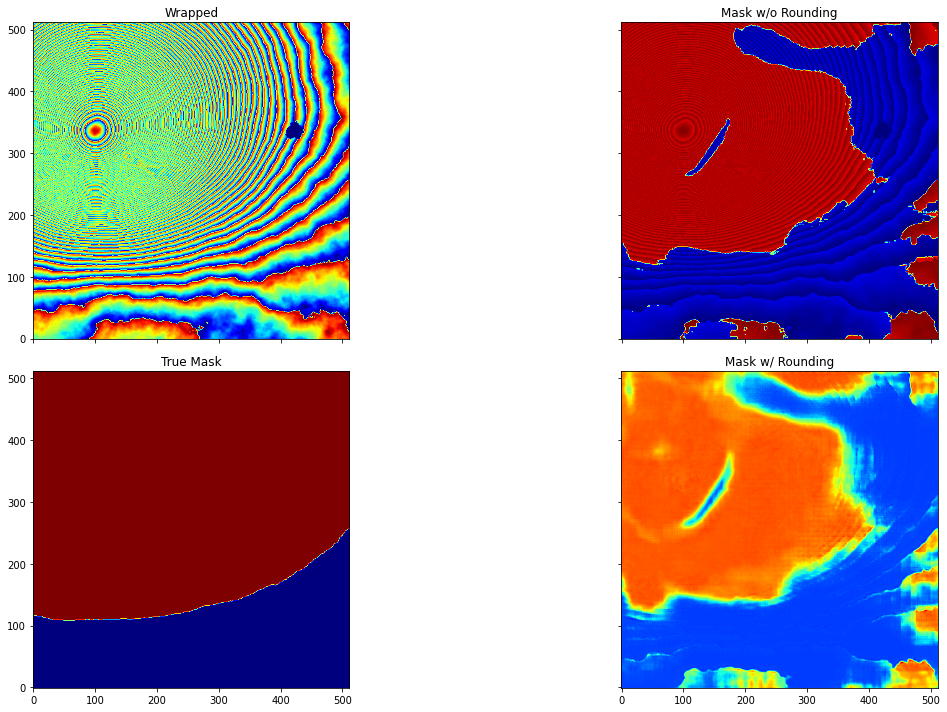

Event Prediction: [[[0.9688]]]


In [10]:
def eval_binary_model(
    mask_model,
    binary_model,
    event_type,
    seed,
    noise_only,
    round_mask,
    zero_output,
    tile_size,
    crop_size,
):
    wrapped, unwrapped, mask_pred, mask_pred_rounded = eval_mask_model(
        mask_model,
        event_type,
        seed,
        noise_only,
        round_mask,
        zero_output,
        tile_size,
        crop_size,
    )

    presence_pred = binary_model.predict(
        mask_pred_rounded.reshape(1, tile_size, tile_size, 1)
    )

    return wrapped, unwrapped, mask_pred, mask_pred_rounded, presence_pred


event_type = "quake"
seed = 0
noise_only = False
round_mask = True
zero_output = False

wrapped, unwrapped, mask_pred, mask_pred_rounded, presence_pred = eval_binary_model(
    mask_model,
    binary_model,
    event_type,
    seed,
    noise_only,
    round_mask,
    zero_output,
    tile_size,
    crop_size,
)

plot_imgs(wrapped, unwrapped, mask_pred, mask_pred_rounded)

print(f"Event Prediction: {presence_pred[0]}")

### Run Inference on a Real Interferogram

Finally, now that we have working masking and classification models, we can generate a mask and a presence prediction for a real interferogram.

In [11]:
from insar_eventnet.inference import mask_with_model
from insar_eventnet.io import get_image_array

image_path = "tests/test_image.tif"
wrapped, _ = get_image_array(image_path)

mask, presence_mask, presence_values = mask_with_model(
    mask_model=mask_model,
    pres_model=binary_model,
    arr_w=wrapped,
    tile_size=tile_size,
    crop_size=crop_size,
)

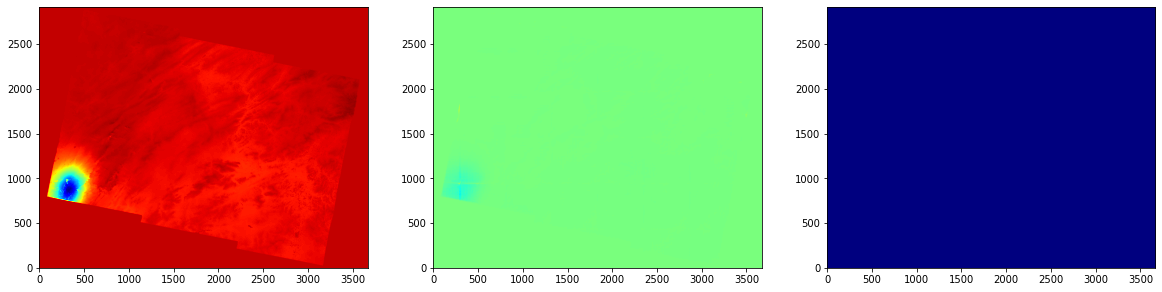

In [12]:
_, [axs_wrapped, axs_mask, axs_presence_mask] = plt.subplots(1, 3)

axs_wrapped.imshow(wrapped, origin="lower", cmap="jet")
axs_mask.imshow(mask, origin="lower", cmap="jet")
axs_presence_mask.imshow(presence_mask, origin="lower", cmap="jet")